Import basic packages

In [1]:
#
import numpy as np
import pandas as pd
import sklearn

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# MNIST 

Load mnist data. Use the first 60000 instances as training data and remaining instances as test data.

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [3]:
X, y = mnist.data, mnist.target

In [4]:
X_train, y_train = X[:60000, :], y[:60000]
X_test, y_test = X[60000:, :], y[60000:]

Visualize instance 0 of X_train.

In [5]:
image0 = X_train[0, :].reshape((28, -1))

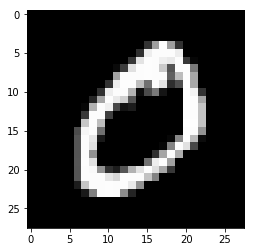

In [6]:
plt.imshow(image0, cmap=plt.cm.gray)

In [7]:
y_train[0]

0.0

Now shuffle the training data.

In [8]:
idx = np.random.permutation(X_train.shape[0])
X_train = X_train[idx, :]
y_train = y_train[idx]

# Training a Binary Classifier

Now we only build a binary classifer to detect whether a digit is 5 or not. Run next cell to create the required data.

In [9]:
#
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

Use SGDClassifier to build a linear classifier at random state 42 and max_iter = 1000. And predict it at X_train[0]

In [10]:
from sklearn.linear_model import SGDClassifier

In [11]:
sgd_clf = SGDClassifier(max_iter=1000, random_state=42)

In [12]:
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict(X_train[0, np.newaxis])

array([False])

Now use cross validation to fit and validate sgd_clf. Print out the accuracy in each iteration.

In [13]:
from sklearn.model_selection import cross_val_score

In [14]:
cv_clf = cross_val_score(sgd_clf, X_train, y_train_5, scoring='accuracy', cv=5)

In [15]:
print('Accuracy: ', cv_clf)

Accuracy:  [0.96175319 0.90483333 0.95633333 0.96325    0.96674723]


Now let us do something interesting. Define an "Never5Classifier" estimator class inheritated from BaseEstimator. This new estimator do nothing but always predict 'False'. Then use cross validation to print out its accuracy. You can see that such a classifier can reach 90% accuracy. This is because the data sets are highly skewed. Generally, accuracy is NOT good enough to evaluate the model performance.

In [16]:
from sklearn.base import BaseEstimator

In [17]:
class Never5Classifier(BaseEstimator):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.repeat([False], X.shape[0])

In [18]:
never5_clf = Never5Classifier()

In [19]:
cv_never5 = cross_val_score(never5_clf, X_train, y_train_5, scoring='accuracy', cv=5)
print('Accuracy of never5 classifier: ', cv_never5)

Accuracy of never5 classifier:  [0.90683333 0.91025    0.91225    0.9115     0.90741667]


Now use cross validation again on sgd_clf. But this time we get the predictions on validation folders in each iteration.

In [20]:
from sklearn.model_selection import cross_val_predict

In [21]:
cv_sgd_clf_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

Now compute the confusion matrix of sdg_clf

In [22]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_train_5, cv_sgd_clf_pred)

In [23]:
cf # c[i, j]: number of group i predicted as group j

array([[52719,  1860],
       [ 1105,  4316]])

Now compute the precision and recall (true positive rate) from the confustion matrix.

In [24]:
# precision = TP / (TP + FP)
# recall = TP / (TP + FN)
TP = cf[1, 1]; FP = cf[0, 1]; FN = cf[1, 0]
precision = TP / (TP + FP)
recall = TP / (TP + FN)

In [25]:
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))

Precision: 0.70
Recall: 0.80


Now use sklearn function to compute the precision and recall again.

In [26]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [27]:
precision_score(y_train_5, cv_sgd_clf_pred)

0.6988341968911918

In [28]:
recall_score(y_train_5, cv_sgd_clf_pred)

0.7961630695443646

Now calculate the F1 score from precision and recall. This allows us to evaluate the model performance by one metric. F1 score is good metric if false positive and false negative are equally weighted.

In [29]:
F1 = 2/(1/precision + 1/recall)
print("F1 score: {:.2f}".format(F1))

F1 score: 0.74


You can also use sklearn to compute F1 score.

In [30]:
from sklearn.metrics import f1_score

In [31]:
f1_score(y_train_5, cv_sgd_clf_pred)

0.7443304302836941

Print out the decision function value at some_digit = X_train[3]

In [32]:
sgd_clf.decision_function(X_train[3, np.newaxis])

array([-1269.12185257])

By default the prediction is positive (1) if the decision function is larger than threshold=0. Now run cross validation again, but instead of returning the prediction we return the the decision function score as y_scores

In [33]:
y_score = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

Plot the precision-recall curve by sklearn

In [34]:
from sklearn.metrics import precision_recall_curve

In [35]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_score)

Plot threshold vs. recall and threshold vs precision in one figure. You can simply select the threshold value that gives you the best precision/recall tradeoff.

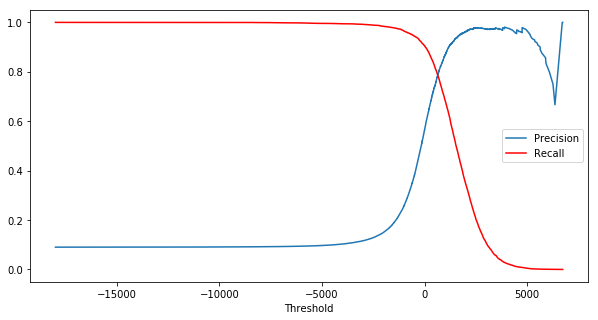

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(thresholds, precisions[:-1], label='Precision')
ax.plot(thresholds, recalls[:-1], color='r', label='Recall')
ax.set_xlabel('Threshold')
ax.legend()

Now plot the ROC curve of sgd_clf.

In [37]:
from sklearn.metrics import roc_curve

In [38]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_score)

(0, 1)

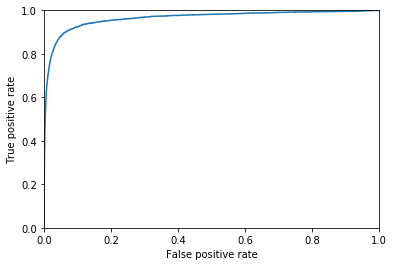

In [39]:
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim([0, 1])
plt.ylim([0, 1])

And compute the area under the curve, i.e., the ROC-AUC score.

In [40]:
from sklearn.metrics import roc_auc_score

In [41]:
roc_auc_score(y_train_5, y_score)

0.9644868488889847

Now build a random forest model and compute the auc again.

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
rf_clf = RandomForestClassifier()

In [44]:
rf_score = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [45]:
roc_auc_score(y_train_5, rf_score[:, 1])

0.9927972230116664

Plot the ROC curves of random forest and SGD in a single figure.

In [46]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train_5, rf_score[:, 1])

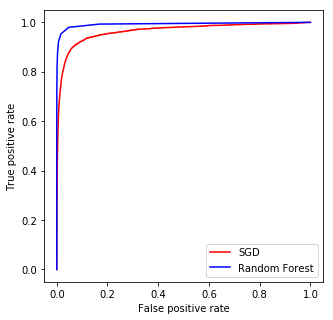

In [47]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, 'r-', label='SGD')
plt.plot(fpr_rf, tpr_rf, 'b-', label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

# Multiclass classification

Scikit-learn uses one-versus-all strategy to build multiclass classification model using binary classifier such as logistic regression. But for support vector machine (SVM) it uses one-versus-one strategy since SVM scales poorly with the size of the training set.

Now fit sgd_clf on X_train and y_train to build multiclass classification model.

In [48]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

/home/chris/ml/env/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

Predict on X_train[0]

In [49]:
sgd_clf.predict(X_train[0, np.newaxis])

array([7])

Calculate the decision function score of X_train[0]

In [50]:
sgd_clf.decision_function(X_train[0, np.newaxis])

array([[ -328484.50595698, -1144334.04134034,  -420992.41483485,
         -295229.47661351,  -738658.59043545,  -639449.18565011,
         -899355.514653  ,   396040.77861102,  -484075.12145653,
         -517768.12412219]])

One the other hand, random forest is a multi-class classifier by itselt, so the one-versus-all or one-vresus-one strategy is not needed. Now train a random forest model on X_train and y_train.

In [51]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Calculate the probability of each class for X_train[0].

In [52]:
rf_clf.predict_proba(X_train[0, np.newaxis])

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

Cacluate the cross validation score of random forest classifier

In [53]:
y_score_rf = cross_val_score(rf_clf, X_train, y_train, scoring='accuracy')

Calculate the confusion matrix of the prediction from sgd_clf

In [54]:
y_pred_rf = cross_val_predict(rf_clf, X_train, y_train)

In [55]:
con_matrix_rf = confusion_matrix(y_train, y_pred_rf)

In [56]:
con_matrix_rf

array([[5810,    2,   19,   13,    4,   13,   25,    3,   29,    5],
       [   1, 6629,   42,    7,    9,   11,   11,   11,   14,    7],
       [  44,   26, 5643,   46,   40,   18,   29,   49,   45,   18],
       [  23,   12,  157, 5623,   11,  109,   11,   63,   84,   38],
       [  17,   16,   25,   12, 5546,   13,   39,   22,   15,  137],
       [  46,   24,   11,  181,   29, 4962,   59,    5,   64,   40],
       [  49,   13,   31,    7,   26,   67, 5701,    0,   21,    3],
       [  10,   32,   98,   28,   68,    9,    0, 5910,   11,   99],
       [  29,   62,   97,  142,   37,  109,   52,   14, 5224,   85],
       [  30,   15,   32,   93,  177,   54,    7,   96,   62, 5383]])

Visualize the confusion matrix in a gray scale color

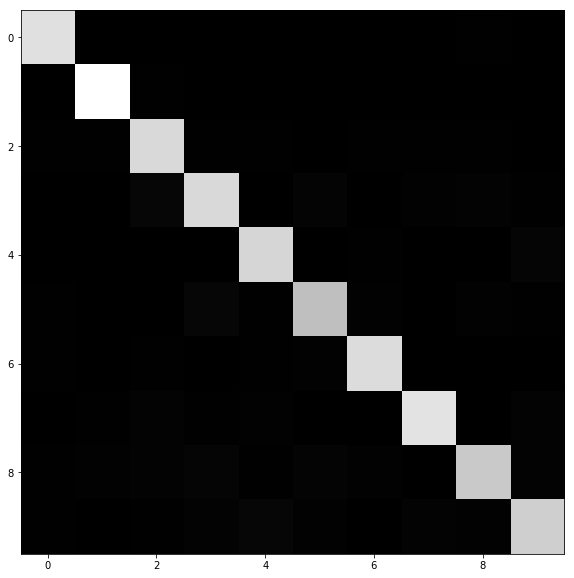

In [57]:
plt.figure(figsize=(10, 10))
plt.imshow(con_matrix_rf, cmap=plt.cm.gray)

Now divide each element by the number of images in each class. Then fill the diagonals at 0. Then visualize the normalized confusion matrix.

In [58]:
class_size = np.sum(con_matrix_rf, axis=1)
class_size = class_size.reshape((-1, 1))

In [59]:
class_size

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [60]:
con_matrix_rf_norm = con_matrix_rf/class_size

In [61]:
np.fill_diagonal(con_matrix_rf_norm, 0)

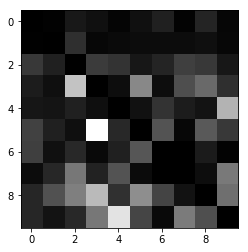

In [62]:
plt.imshow(con_matrix_rf_norm, cmap=plt.cm.gray)

# Multilabel Classification

Run next cell the create multilabel.

In [63]:
#
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

Now use KNeighborsClassifer to train a fit a multilabel classification model

In [64]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Predict on X_train[0]. Also check the true answer.

In [66]:
knn_clf.predict(X_train[0, np.newaxis])

array([[ True,  True]])